# Модуль А. Анализ и предобработка данных

## Подготовка рабочего пространства

### Импортирование библиотек

In [2]:
# для работы с датафреймами
import pandas as pd

# для работы с файловой системой
import os

# для визуализации результатов
import matplotlib.pyplot as plt

# для преобразования текста
import nltk
from nltk.corpus import stopwords

# для работы с датасетами
from datasets import Dataset, DatasetDict

# для обработки текста
from pymystem3 import Mystem

# токенизатор
from transformers import T5Tokenizer

# модуль для разбиения на слова
from nltk import  word_tokenize

# для работы со строками
import string

# для работы с регулярными функциями
import re

### Настройка переменных и загрузка дополнительных параметров

Применяем стиль для графиков

In [3]:
plt.style.use('dark_background')

Скачиваем стоп-слова для русского языка

In [6]:
nltk.download('stopwords')
# сохраняем стоп-слова в множество 
stop_words = set(stopwords.words('russian'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Вспомогательные функции

Функция для чистки текста

In [21]:
def clean_text(text: str, stop_words: set) -> str:
    '''
    Функция для чистки текста от стоп слов
        Args:
            - test (str): текст, который нужно почистить от стоп слов
            - stop_words (set): множество стоп слов
        Returns:
            - отфильтрованный текст (str)
    '''
     # создаем список слов используя split()
    words = text.split()
    # фильтруем слова используя заданное множество
    filtered_words = [word for word in words if word.lower() not in stop_words]
    # возвращаем почищенный текст
    return ' '.join(filtered_words)

Функция для создания датасета из путя

In [30]:
def reorganize_dataset(data_path: str) -> DatasetDict:
    '''
    Функция для создания датасета формата DatasetDict из папки с данными
    '''
    # создаем список для примеров
    samples = []
    # собираем все примеры
    for folder in os.listdir(data_path):
        # путь к папке
        folder_path = os.path.join(data_path, folder)
        # проверяем, папка ли это
        if os.path.isdir(folder_path):
            # получаем путь к тексту и аннотации
            text_path = os.path.join(folder_path, 'text.txt')
            annotation_path = os.path.join(folder_path, 'annotation.txt')
            tags_path = os.path.join(folder_path, 'tags.txt')

            # проверяем, существуют ли эти файлы
            if os.path.exists(text_path) and os.path.exists(annotation_path) and os.path.exists(tags_path):
                # открываем и читаем файл с текстом
                with open(text_path, 'r', encoding='utf-8') as f:
                    text = f.read().strip()
                
                # открываем и читаем файл с аннотацией
                with open(annotation_path, 'r', encoding='utf-8') as f:
                    summary = f.read().strip()
                
                # открываем и читаем файл с тегами
                with open(tags_path, 'r', encoding='utf-8') as f:
                    tag = f.read().strip()
                
                # сохраняем элемент в список
                samples.append({
                    'text_path': text_path,
                    'annotation_path': annotation_path,
                    'tags_path': tags_path,

                    'text': text,
                    'summary': summary,
                    'tag': tag,

                    'text_all_symb': len(text),
                    'summary_all_symb': len(summary),
                    'tag_all_symb': len(tag),

                    'text_no_symb': len(re.sub(r'[{}]'.format(string.punctuation), '', text)),
                    'summary_no_symb': len(re.sub(r'[{}]'.format(string.punctuation), '', summary)),
                    'tag_no_symb': len(re.sub(r'[{}]'.format(string.punctuation), '', tag)),

                    'text_words': len(word_tokenize(text)),
                    'summary_words': len(word_tokenize(summary)),
                    'tag_words': len(word_tokenize(tag)),

                    'text_no_symb': len(re.sub(r'[{}]'.format(string.punctuation), '', text)),
                    'summary_no_symb': len(re.sub(r'[{}]'.format(string.punctuation), '', summary)),
                    'tag_no_symb': len(re.sub(r'[{}]'.format(string.punctuation), '', tag)),

                    'text_clean': clean_text(text, stop_words),
                    'summary_clean': clean_text(summary, stop_words),
                    'tag_clean': clean_text(tag, stop_words),

                    'id': folder

                })
    
    return samples

Функиця для фильтрации датафрейма

In [55]:
def df_filter(
    df: pd.DataFrame,
    column: str,
    upper: float = 0.95,
    lower: float = 0.05
):
    '''
    Функция для фильтрации датасета по квартилям
    ======
        **Args**:
            - df (pd.DataFrame): датасета для фильтрации
            - column (str): название колонки для фильтрации
            - upper (float = 0.95): верхний квартиль
            - lower (float = 0.05): нижний квартиль

        **Returns**:
            - filter_df (pd.DataFrame): отфильтрованный датасет

    Пример использования:
    ===

    ```python
    >>  from function import df_filter
    >> 
    >>  for column in df.columns:
    >>      if 'int64' == df[column].dtype:
    >>          filtered_df = df_filter(filtered_df, column)

    ```
    '''
    # верхняя граница 
    upper_bound = df[column].quantile(upper)
    # нижняя граница
    lower_bound = df[column].quantile(lower)

    # фильтрую датасет
    filtered_df = df[
        (df[column] >= lower_bound) & (df[column] <= upper_bound)
    ]

    # возвращаю отфильтрованный датасет
    return filtered_df.dropna()


## Анализ данных

In [31]:
# назначаем путь к данным
data_path = 'Data/DATASET'
# проверяем правильный ли путь
print(f'Путь существует: {os.path.exists(data_path)}')
# считаем кол-во папок
print(f'Кол-во исходных папок с данными: {len(os.listdir(data_path))}')

Путь существует: True
Кол-во исходных папок с данными: 1002


**Структура исходных данных:**

    -- Data/DATASET/
        -- 1/
            -- annotation.txt
            -- tags.txt
            -- text.txt
        -- 2/
            -- annotation.txt
            -- tags.txt
            -- text.txt
        -- 3/
        -- 4/
        ...
        -- 1002/

**Описание набора данных:**

- `1002` папки с данными
- `annotation.txt`: файл с кратким содержанием статьи
- `tags.txt`: файл с тэгами статьи
- `text.txt`: файл с текстом статьи

In [32]:
dataset = Dataset.from_list(reorganize_dataset(data_path))
dataset

Dataset({
    features: ['text_path', 'annotation_path', 'tags_path', 'text', 'summary', 'tag', 'text_all_symb', 'summary_all_symb', 'tag_all_symb', 'text_no_symb', 'summary_no_symb', 'tag_no_symb', 'text_words', 'summary_words', 'tag_words', 'text_clean', 'summary_clean', 'tag_clean', 'id'],
    num_rows: 1002
})

In [33]:
# получаю датафрейм в формате pd.DataFrame
df_baseline = pd.DataFrame(dataset)
# вывожу 5 первых строк датафрейма
df_baseline.head()

,text_path,annotation_path,tags_path,text,summary,tag,text_all_symb,summary_all_symb,tag_all_symb,text_no_symb,summary_no_symb,tag_no_symb,text_words,summary_words,tag_words,text_clean,summary_clean,tag_clean,id
0,Data/DATASET\1\text.txt,Data/DATASET\1\annotation.txt,Data/DATASET\1\tags.txt,Важнейшим вопросом для организации обучения яв...,В электронном учебнике изложены основные разде...,"БАЗА ДАННЫХ, MACROMEDIA FLASH, LIBRARY, ACTION...",5160,379,52,5061,374,49,720,52,9,Важнейшим вопросом организации обучения являет...,электронном учебнике изложены основные разделы...,"БАЗА ДАННЫХ, MACROMEDIA FLASH, LIBRARY, ACTION...",1
1,Data/DATASET\10\text.txt,Data/DATASET\10\annotation.txt,Data/DATASET\10\tags.txt,Фреймворк - это набор концептуальной структуры...,В этой статье рассматривается Laravel - PHP-фр...,"РАЗРАБОТКА, BACK-END РАЗРАБОТКА, ЗАПРОСЫ, СЕРВ...",6075,212,62,5917,205,58,862,32,9,Фреймворк - это набор концептуальной структуры...,статье рассматривается Laravel - PHP-фреймворк...,"РАЗРАБОТКА, BACK-END РАЗРАБОТКА, ЗАПРОСЫ, СЕРВ...",10
2,Data/DATASET\100\text.txt,Data/DATASET\100\annotation.txt,Data/DATASET\100\tags.txt,В современном мире цифровая трансформация стал...,Тема финансовой кибербезопасности в условиях ц...,"ФИШИНГ, КИБЕРБЕЗОПАСНОСТЬ, ЦИФРОВЫЕ ТЕХНОЛОГИИ...",6692,569,67,6586,564,64,899,74,9,современном мире цифровая трансформация стала ...,Тема финансовой кибербезопасности условиях циф...,"ФИШИНГ, КИБЕРБЕЗОПАСНОСТЬ, ЦИФРОВЫЕ ТЕХНОЛОГИИ...",100
3,Data/DATASET\1000\text.txt,Data/DATASET\1000\annotation.txt,Data/DATASET\1000\tags.txt,Разница между ASP.NET и PHP\nASP.NET - это сер...,В статье описана разница между серверной веб-п...,"ASP.NET, PHP, РАЗЛИЧИЯ, DIFFERENCES",5525,172,35,5356,166,31,827,22,7,Разница ASP.NET PHP ASP.NET - это серверная ве...,статье описана разница серверной веб-платформо...,"ASP.NET, PHP, РАЗЛИЧИЯ, DIFFERENCES",1000
4,Data/DATASET\1001\text.txt,Data/DATASET\1001\annotation.txt,Data/DATASET\1001\tags.txt,"Всему миру известен данный модный дом, каждая ...","Как появилось имя Коко Шанель? Кто она, создат...","КОКО ШАНЕЛЬ, МОДА XX ВЕКА, ДУХИ CHANEL № 5, МА...",12202,226,68,11905,220,65,2172,41,15,"Всему миру известен данный модный дом, каждая ...","появилось имя Коко Шанель? она, создательница ...","КОКО ШАНЕЛЬ, МОДА XX ВЕКА, ДУХИ CHANEL № 5, МА...",1001


array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >], dtype=object)

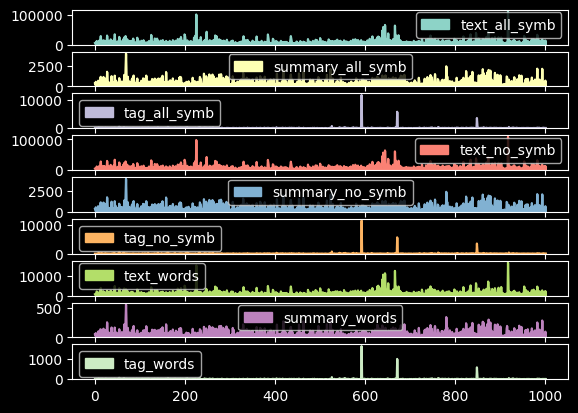

In [34]:
# визуализирую каждую числовую колонку
df_baseline.plot(kind='area', subplots=True)

In [35]:
# вывожу описание числовых колонок датафрейма
df_baseline.describe()

,text_all_symb,summary_all_symb,tag_all_symb,text_no_symb,summary_no_symb,tag_no_symb,text_words,summary_words,tag_words
count,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000
mean,9243.906188,494.934132,118.254491,8970.108782,485.199601,112.265469,1409.502994,67.470060,17.867265
std,8165.170347,390.030148,426.569564,7920.992738,382.093134,415.891918,1291.837399,53.843648,64.391064
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5049.000000,243.000000,57.000000,4905.250000,240.000000,53.000000,763.250000,33.000000,9.000000
50%,7259.500000,380.500000,85.000000,7041.000000,374.000000,79.500000,1113.000000,51.000000,13.000000
75%,10678.750000,606.000000,120.000000,10412.750000,593.000000,114.000000,1619.500000,82.000000,18.000000
max,111644.000000,4082.000000,11641.000000,108116.000000,4007.000000,11354.000000,16993.000000,561.000000,1661.000000


In [60]:
%%time

# логирование
print(f'Размер датасета до: {df_baseline.shape}')
# копируем датасет
df_filtered = df_baseline.copy(deep=True)
# проходимся по каждой колонке в датафрейме
for column in df_filtered.columns:
    # проверяем тип данных в таблице
    if df_filtered[column].dtype == 'int64':
        # фильтруем колонку используя df_filter
        df_filtered = df_filter(df_filtered, column, upper=0.95, lower=0.01)

# логирование
print(f'Размер датасета после: {df_filtered.shape}')
# вывожу первые 5 строчек датафрейма
df_filtered.head()

Размер датасета до: (1002, 19)
Размер датасета после: (578, 19)
CPU times: total: 31.2 ms
Wall time: 21.9 ms


,text_path,annotation_path,tags_path,text,summary,tag,text_all_symb,summary_all_symb,tag_all_symb,text_no_symb,summary_no_symb,tag_no_symb,text_words,summary_words,tag_words,text_clean,summary_clean,tag_clean,id
0,Data/DATASET\1\text.txt,Data/DATASET\1\annotation.txt,Data/DATASET\1\tags.txt,Важнейшим вопросом для организации обучения яв...,В электронном учебнике изложены основные разде...,"БАЗА ДАННЫХ, MACROMEDIA FLASH, LIBRARY, ACTION...",5160,379,52,5061,374,49,720,52,9,Важнейшим вопросом организации обучения являет...,электронном учебнике изложены основные разделы...,"БАЗА ДАННЫХ, MACROMEDIA FLASH, LIBRARY, ACTION...",1
1,Data/DATASET\10\text.txt,Data/DATASET\10\annotation.txt,Data/DATASET\10\tags.txt,Фреймворк - это набор концептуальной структуры...,В этой статье рассматривается Laravel - PHP-фр...,"РАЗРАБОТКА, BACK-END РАЗРАБОТКА, ЗАПРОСЫ, СЕРВ...",6075,212,62,5917,205,58,862,32,9,Фреймворк - это набор концептуальной структуры...,статье рассматривается Laravel - PHP-фреймворк...,"РАЗРАБОТКА, BACK-END РАЗРАБОТКА, ЗАПРОСЫ, СЕРВ...",10
2,Data/DATASET\100\text.txt,Data/DATASET\100\annotation.txt,Data/DATASET\100\tags.txt,В современном мире цифровая трансформация стал...,Тема финансовой кибербезопасности в условиях ц...,"ФИШИНГ, КИБЕРБЕЗОПАСНОСТЬ, ЦИФРОВЫЕ ТЕХНОЛОГИИ...",6692,569,67,6586,564,64,899,74,9,современном мире цифровая трансформация стала ...,Тема финансовой кибербезопасности условиях циф...,"ФИШИНГ, КИБЕРБЕЗОПАСНОСТЬ, ЦИФРОВЫЕ ТЕХНОЛОГИИ...",100
3,Data/DATASET\1000\text.txt,Data/DATASET\1000\annotation.txt,Data/DATASET\1000\tags.txt,Разница между ASP.NET и PHP\nASP.NET - это сер...,В статье описана разница между серверной веб-п...,"ASP.NET, PHP, РАЗЛИЧИЯ, DIFFERENCES",5525,172,35,5356,166,31,827,22,7,Разница ASP.NET PHP ASP.NET - это серверная ве...,статье описана разница серверной веб-платформо...,"ASP.NET, PHP, РАЗЛИЧИЯ, DIFFERENCES",1000
5,Data/DATASET\1002\text.txt,Data/DATASET\1002\annotation.txt,Data/DATASET\1002\tags.txt,При разработке веб-сайта перед любым разработч...,В данной статье представлен метод разработки в...,"ПРОГРАММИРОВАНИЕ, ВЕБ-ПРОГРАММИРОВАНИЕ, БАЗА Д...",6776,301,107,6580,295,99,1043,41,17,разработке веб-сайта любым разработчиком возни...,данной статье представлен метод разработки веб...,"ПРОГРАММИРОВАНИЕ, ВЕБ-ПРОГРАММИРОВАНИЕ, БАЗА Д...",1002


In [61]:
df_filtered.describe()

,text_all_symb,summary_all_symb,tag_all_symb,text_no_symb,summary_no_symb,tag_no_symb,text_words,summary_words,tag_words
count,578.000000,578.000000,578.000000,578.000000,578.000000,578.000000,578.000000,578.000000,578.000000
mean,6794.935986,345.993080,77.141869,6596.520761,339.647059,72.628028,1032.683391,46.591696,11.569204
std,2622.619359,160.966911,31.134593,2561.431917,158.080755,29.848521,393.540564,21.632732,4.593291
min,2274.000000,94.000000,19.000000,2192.000000,92.000000,18.000000,370.000000,14.000000,3.000000
25%,4811.000000,221.500000,53.000000,4675.500000,218.000000,49.250000,732.250000,30.000000,8.000000
50%,6503.000000,313.000000,74.000000,6249.500000,307.000000,70.000000,975.000000,43.000000,11.000000
75%,8405.750000,444.000000,101.000000,8179.250000,434.000000,95.000000,1296.500000,59.000000,15.000000
max,14977.000000,867.000000,153.000000,14715.000000,854.000000,147.000000,2094.000000,109.000000,22.000000


In [ ]:
cols = [col for col in df_filtered.columns if col.startswith('text') or col.startswith('summary')]

In [70]:
df_filtered[cols].describe()

,text_all_symb,summary_all_symb,text_no_symb,summary_no_symb,text_words,summary_words
count,578.000000,578.000000,578.000000,578.000000,578.000000,578.000000
mean,6794.935986,345.993080,6596.520761,339.647059,1032.683391,46.591696
std,2622.619359,160.966911,2561.431917,158.080755,393.540564,21.632732
min,2274.000000,94.000000,2192.000000,92.000000,370.000000,14.000000
25%,4811.000000,221.500000,4675.500000,218.000000,732.250000,30.000000
50%,6503.000000,313.000000,6249.500000,307.000000,975.000000,43.000000
75%,8405.750000,444.000000,8179.250000,434.000000,1296.500000,59.000000
max,14977.000000,867.000000,14715.000000,854.000000,2094.000000,109.000000


array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
      dtype=object)

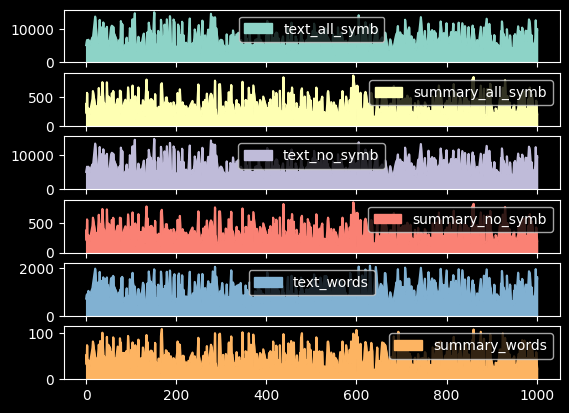

In [72]:
df_filtered[cols].plot(kind='area', subplots=True)